## PSI - Population Stability Index

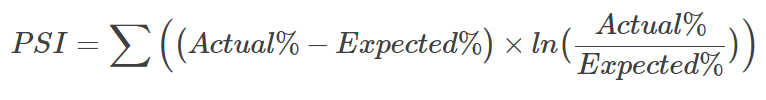

The population stability index (PSI) is a widely used statistic that measures how much a variable has shifted over time. 
- A high PSI may alert the business to a change in the characteristics of a population. 
- This shift may require investigation and possibly a model update. 
- PSI is commonly used among banks to measure the shift between model development data and current data. 
- There are not many studies about the statistical properties of PSI. 

- PSI mainly calculated for score distributions however it can also be applied to any other variables which exist on both current and development data sources.

In practice, the following “rule of thumb” is used:

    PSI < 0.10 means a “little change”, 
    0.10 < PSI < 0.25 means a “moderate change”, 
    PSI > 0.25 means a “significant change, action required”. 

These benchmarks are used without reference to statistical type I or type II error rates. 

Population change may occur for many reasons:

    - change in the economic environment
    - strategic change in the business
    - policy changes within the company
    - changes in regulatory environment
    - others

#### Other PSI Consideration
- PSI can be written as some form of so called "Kullback-Liebler divergence" defined in Kullback & Leibler (1951).

- There is no such thing as "Data Drift". It is just "Feature Drift"

- No model lives forever, but the speed of decay varies. This is a good scenario to implement a Data-Dift model

- The concept of "drift" occurs when the patterns that the model learned no longer hold. The feature distributions may even remain the same, but the patterns changed.


source:
1. https://www.risk.net/journal-of-risk-model-validation/7725371/statistical-properties-of-the-population-stability-index
2. https://evidentlyai.com/blog/machine-learning-monitoring-data-and-concept-drift


Paper: Statistical Properties of Population Stability Index  
https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations


PATENTE:
http://patentimages.storage.googleapis.com/pdfs/US8326575.pdf
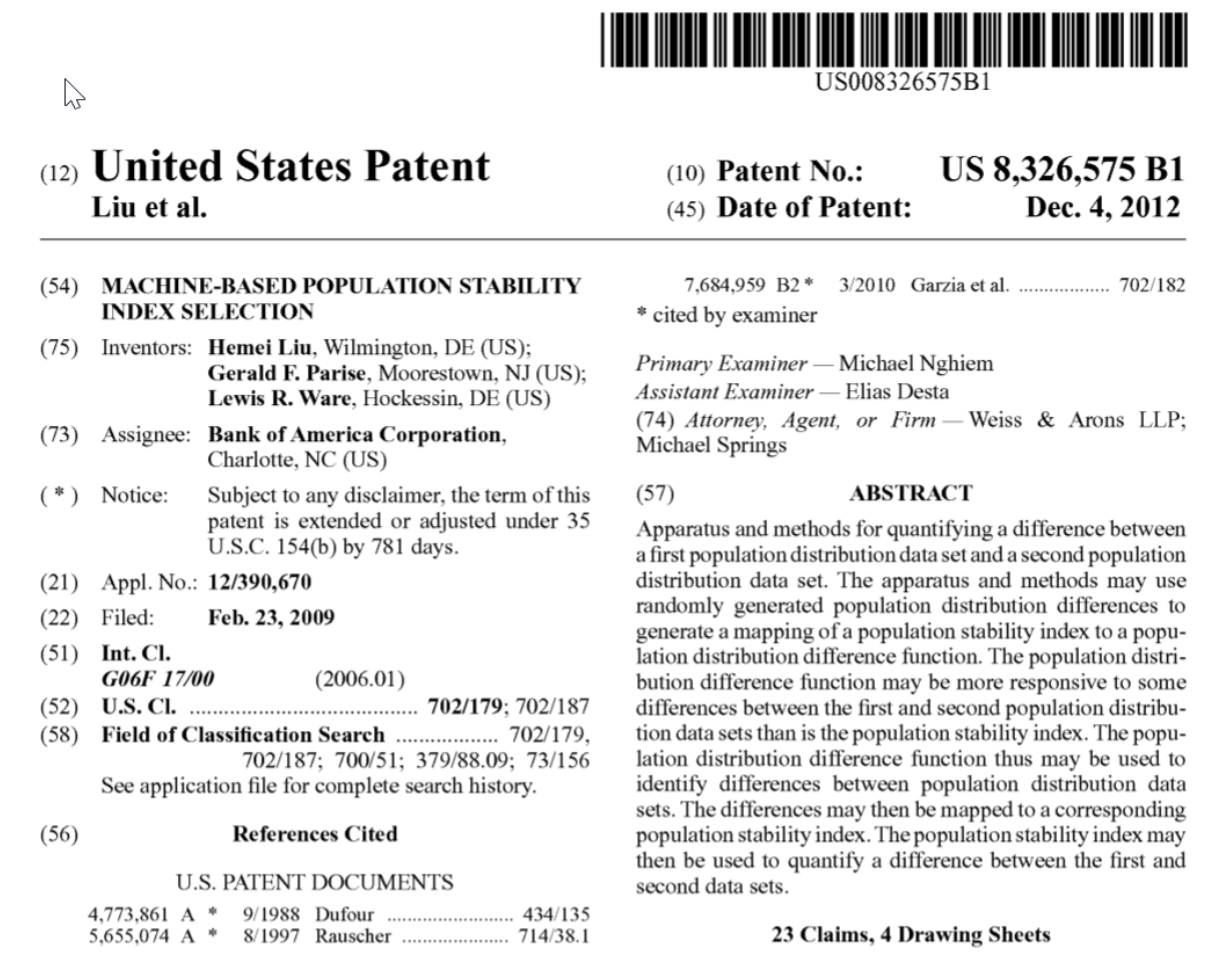

In [130]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# PSI 
### Example calculation

In [131]:
df = sns.load_dataset('titanic')
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [132]:
# train test split
train, test = train_test_split(df, test_size=0.5)

# One variable PSI calculation
var_test = 'embark_town'
train_frec = train[var_test].value_counts(normalize=True).rename('train_freq')
test_frec = test[var_test].value_counts(normalize=True).replace(0, 0.000001).rename('test_freq')
diff_train_test = (train_frec - test_frec).rename('diff_train-test')
diff_ln = (np.log(train_frec / test_frec)).rename('diff_ln_train-test')
product_diff_ln = (diff_train_test * diff_ln).rename('product_diff_ln')

#create pandas dataframe
ps_tbl = pd.concat([train_frec, test_frec, diff_train_test, diff_ln, product_diff_ln], axis=1)
ps_tbl.replace([np.inf, -np.inf], np.nan, inplace=True)
ps_tbl

,train_freq,test_freq,diff_train-test,diff_ln_train-test,product_diff_ln
Southampton,0.737079,0.711712,0.025367,0.035022,0.000888
Cherbourg,0.179775,0.198198,-0.018423,-0.097560,0.001797
Queenstown,0.083146,0.090090,-0.006944,-0.080211,0.000557


In [133]:
# Final PSI result betweeen train and test for embark_town
ps_tbl['product_diff_ln'].sum()


0.003242719506569048

# Functions

In [134]:
def calculate_psi_categorical(actual, expected, smoothing=0.000001):
    #na_validator([actual, expected])
    actual_freq = actual.dropna().astype('str').value_counts(normalize=True)
    expected_freq = expected.dropna().astype('str').value_counts(normalize=True)

    PSI = 0
    classes = {*set(actual_freq.index), *set(expected_freq.index)}
    for c in classes:
        actual_freq_c = float(actual_freq.get(c, default=smoothing))
        expected_freq_c = float(expected_freq.get(c, default=smoothing))
        PSI += (actual_freq_c - expected_freq_c) * np.log(actual_freq_c / expected_freq_c)
    return PSI


def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    source: github.com/mwburke/population-stability-index
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input_, min_, max_):
            input_ += -(np.min(input_))
            input_ /= np.max(input_) / (max_ - min_)
            input_ += min_
            return input_


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

def get_num_cols(df):
    return list(df.select_dtypes(include=np.number).columns)

def get_date_cols(df):
    date_cols = []
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            date_cols.append(col)
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            continue
        try:
            _ = pd.to_datetime(df[col])
            date_cols.append(col)
        except:
            continue
    return date_cols

def get_cat_cols(df):
    date_cols = get_date_cols(df)
    num_cols = list(df.select_dtypes(include=np.number).columns)
    return [x for x in df.columns if x not in date_cols + num_cols]

def data_drift(df1, df2, categoricals, numericals):
    results = []
    for feature_name in categoricals:
        psi = calculate_psi_categorical(df1[feature_name], df2[feature_name])
        results.append([feature_name, 'categorical', psi])
    for feature_name in numericals:
        psi = calculate_psi(df1[feature_name], df2[feature_name], buckettype='quantiles', buckets=3, axis=0)
        results.append([feature_name, 'numerical', psi])  
    return results

def na_validator(features, threshold = 0.3):
    for feature in features:
        na_ratio = feature.isna().value_counts(normalize=True)
        if feature.isna().any() and na_ratio[True] >= threshold:
            print('Warning! Percentage of nan for Feature', feature.name, round(na_ratio[True], 2))

def get_psi_df(df, test_size=0.3):
    #get num and cat cols
    cols_cat = get_cat_cols(df)
    cols_num = get_num_cols(df)

    # train test split
    train, test = train_test_split(df, test_size=test_size)

    # psi calculation
    results = data_drift(train, test, cols_cat, cols_num)
    df_psi = pd.DataFrame(results, columns=['feature', 'type', 'PSI'])
    df_psi = df_psi.sort_values(by=['PSI'], ascending=False)
    return df_psi

def get_psi_iter(df, split_start=.5, split_step=.1, psi_treshold=.25):
    #get num and cat cols
    cols_cat = get_cat_cols(df)
    cols_num = get_num_cols(df)

    split_range =  np.arange(start=split_start, stop=1, step=split_step)
    
    df_psi_final= pd.DataFrame()
    for split_size in split_range:
        # train test split
        train, test = train_test_split(df, test_size=1-split_size)
        # psi calculation
        results = data_drift(train, test, cols_cat, cols_num)
        df_psi = pd.DataFrame(results, columns=['feature', 'type', 'PSI'])
        df_psi['train_size'] = str(round(split_size, 2))
        df_psi['significant_change'] = df_psi['PSI'] > psi_treshold
        df_psi = df_psi.sort_values(by=['PSI'], ascending=False)
        df_psi_final = pd.concat([df_psi_final, df_psi], axis=0)
    return df_psi_final

def is_id(s:pd.Series):
    return len(s.unique()) == len(s)
    
def psi_plot(df_psi, red_line=0.25, max_xlim=0.5):
    p = df_psi[['feature', 'PSI']].plot.barh(x='feature', y='PSI', figsize=(10,5))
    p.set_xlim(0, max_xlim)
    p.invert_yaxis()
    p.axvline(red_line,color='red')
    p.axvline(0.1,color='lightgray', alpha=0.6)
    p.axvline(0.2,color='lightgray', alpha=0.6)
    p.axvline(0.3,color='lightgray', alpha=0.6)
    p.axvline(0.4,color='lightgray', alpha=0.6)


## Taxis Dataset

In [135]:
df_taxis = sns.load_dataset('taxis')
df_taxis.sample(2)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
2705,2019-03-15 00:31:49,2019-03-15 00:45:30,1,3.72,14.5,3.66,0.0,21.96,yellow,credit card,Financial District South,Lower East Side,Manhattan,Manhattan
927,2019-03-28 23:19:09,2019-03-28 23:29:17,1,1.53,8.5,1.23,0.0,13.53,yellow,credit card,Midtown East,Murray Hill,Manhattan,Manhattan


In [136]:
df_psi = get_psi_df(df_taxis, test_size=0.5)
df_psi

,feature,type,PSI
3,dropoff_zone,categorical,2.590262e-01
2,pickup_zone,categorical,2.198740e-01
11,total,numerical,1.809122e-03
8,fare,numerical,1.532158e-03
1,payment,categorical,1.151176e-03
4,pickup_borough,categorical,9.758873e-04
5,dropoff_borough,categorical,5.487030e-04
7,distance,numerical,5.467377e-04
0,color,categorical,1.876803e-04
6,passengers,numerical,1.060489e-04


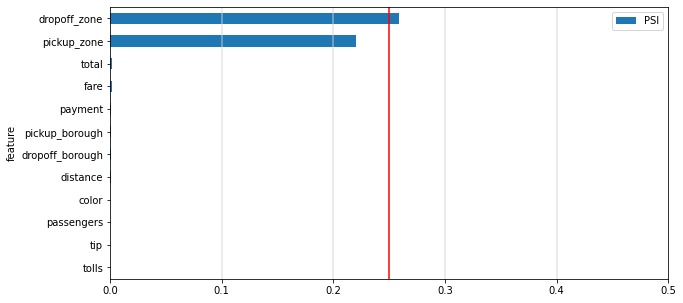

In [137]:
psi_plot(df_psi, red_line=0.25, max_xlim=0.5)

## Tips dataset

In [138]:
df_tips = sns.load_dataset('tips')
df_tips.sample(3)

,total_bill,tip,sex,smoker,day,time,size
151,13.13,2.00,Male,No,Sun,Dinner,2
109,14.31,4.00,Female,Yes,Sat,Dinner,2
37,16.93,3.07,Female,No,Sat,Dinner,3


In [139]:
df_psi = get_psi_df(df_tips, test_size=0.15)
df_psi

,feature,type,PSI
2,day,categorical,1.115450
6,size,numerical,0.101580
0,sex,categorical,0.084399
1,smoker,categorical,0.043351
4,total_bill,numerical,0.019182
3,time,categorical,0.008996
5,tip,numerical,0.006238


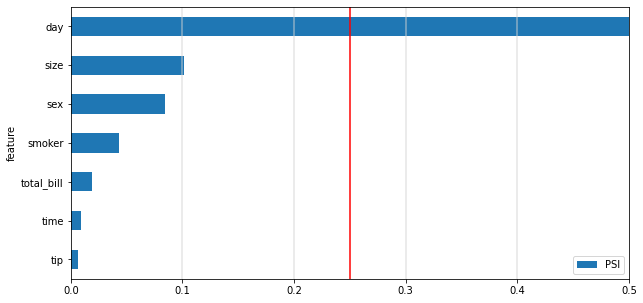

In [140]:
psi_plot(df_psi, red_line=0.25, max_xlim=0.5)

# Iris Dataset

In [141]:
df_iris = sns.load_dataset('iris')
df_iris.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,species
110,6.5,3.2,5.1,2.0,virginica
4,5.0,3.6,1.4,0.2,setosa
128,6.4,2.8,5.6,2.1,virginica


In [142]:
df_psi = get_psi_df(df_iris, test_size=0.1)
df_psi

,feature,type,PSI
4,petal_width,numerical,0.112973
0,species,categorical,0.112460
3,petal_length,numerical,0.092420
2,sepal_width,numerical,0.071637
1,sepal_length,numerical,0.014213


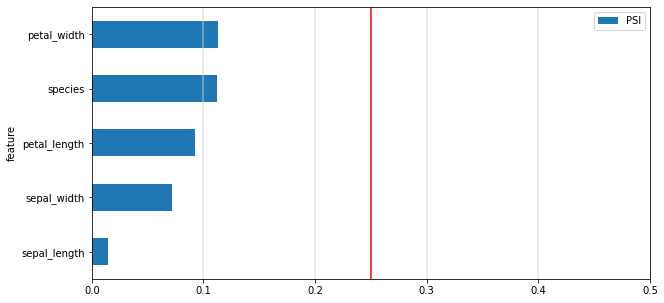

In [143]:
psi_plot(df_psi)

# Churn Dataset

In [144]:
url = 'https://drive.google.com/file/d/1EpihmWBrhwtMMZdKeXtBTr0We_mYcg2d/view?usp=sharing'
url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_churn = pd.read_csv(url2)
df_churn.sample(3)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
3071,NV,110,area_code_408,no,yes,34,192.3,114,32.69,129.3,114,10.99,136.3,102,6.13,6.3,12,1.70,1,0
2654,ME,66,area_code_510,no,no,0,207.7,85,35.31,196.7,112,16.72,261.7,83,11.78,6.8,3,1.84,1,0
2362,ND,101,area_code_415,no,no,0,217.7,118,37.01,231.7,128,19.69,185.3,128,8.34,0.0,0,0.00,3,0


In [145]:
df_psi = get_psi_df(df_churn, test_size=0.1)
df_psi

,feature,type,PSI
0,state,categorical,0.165605
18,number_customer_service_calls,numerical,0.022309
3,voice_mail_plan,categorical,0.016381
13,total_night_calls,numerical,0.012426
16,total_intl_calls,numerical,0.012325
1,area_code,categorical,0.010442
6,total_day_minutes,numerical,0.007523
8,total_day_charge,numerical,0.007523
11,total_eve_charge,numerical,0.006113
9,total_eve_minutes,numerical,0.006101


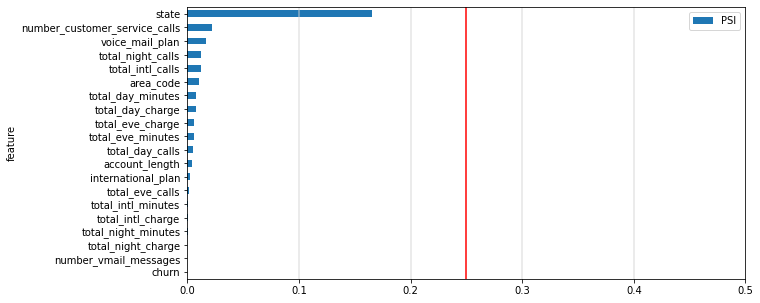

In [146]:
psi_plot(df_psi)

# SEARCH
Search the optimun split

In [160]:
# PSI generation
df_iter_psi = get_psi_iter(df_churn, split_start=.03, split_step=.03)
df_iter_psi.head(3)

,feature,type,PSI,train_size,significant_change
0,state,categorical,1.266386,0.03,True
18,number_customer_service_calls,numerical,0.050410,0.03,False
13,total_night_calls,numerical,0.040245,0.03,False


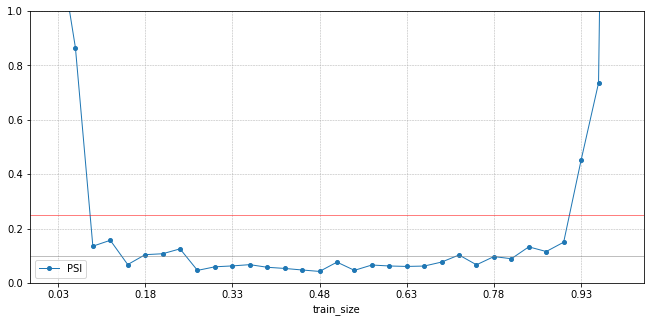

In [161]:
# PLOT
p = (
    df_iter_psi.groupby(["train_size"])
    .agg({"PSI": "max"})
    .plot.line(marker="o", ms=4, linewidth=1, figsize=(11, 5))
    
)
p.axhline(0.25,color='red', linewidth=.5)
p.axhline(0.1,color='gray', linewidth=.5)
p.set_ylim(0,1)
p.grid(True, which='major', axis='both', linestyle='--', linewidth=.5)

#g = df_iter_psi.train_size.unique()
#p.set_xticks(range(len(g)))
#p.set_xticklabels(g, rotation=0)

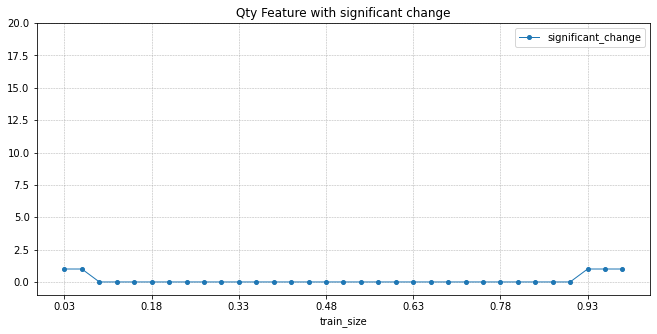

In [162]:
# PLOT
p = (
    df_iter_psi.groupby(["train_size"])
    .agg({"significant_change": "sum"})
    .plot.line(
        marker="o",
        ms=4,
        linewidth=1,
        figsize=(11, 5),
        title="Qty Feature with significant change",
    )
)

p.set_ylim(-1,len(df_iter_psi.feature.unique()))
p.grid(True, which='major', axis='both', linestyle='--', linewidth=.5)




# Visualizations

In [96]:
df_tips = sns.load_dataset('tips')
df_tips.sample(3)

,total_bill,tip,sex,smoker,day,time,size
39,31.27,5.00,Male,No,Sat,Dinner,3
13,18.43,3.00,Male,No,Sun,Dinner,4
206,26.59,3.41,Male,Yes,Sat,Dinner,3


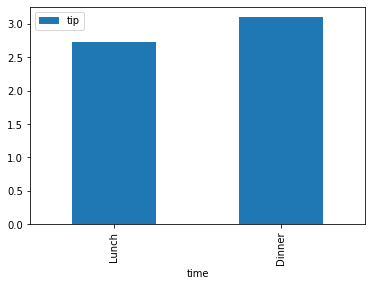

In [97]:
df_tips.groupby(['time']).agg({'tip': 'mean'}).plot.bar()

In [98]:
df_tips.groupby(['sex', 'smoker', 'day']).agg({'tip': 'mean'})

tip
sex    smoker day           
Male   Yes    Thur  3.058000
              Fri   2.741250
              Sat   2.879259
              Sun   3.521333
       No     Thur  2.941500
              Fri   2.500000
              Sat   3.256563
              Sun   3.115349
Female Yes    Thur  2.990000
              Fri   2.682857
              Sat   2.868667
              Sun   3.500000
       No     Thur  2.459600
              Fri   3.125000
              Sat   2.724615
              Sun   3.329286

In [99]:
df_tips.tip.describe()

count    244.000000
mean       2.998279
std        1.383638
min        1.000000
25%        2.000000
50%        2.900000
75%        3.562500
max       10.000000
Name: tip, dtype: float64

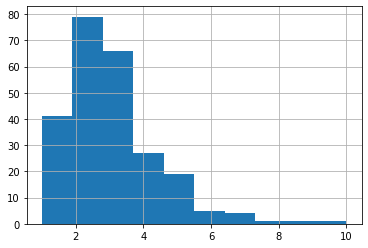

In [100]:
df_tips.tip.hist()

# HISTOGRAM

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


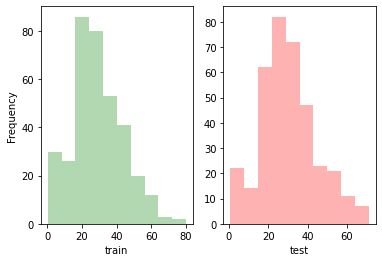

In [101]:
num_var = 'age'
kwargs = dict(alpha=0.3, bins=10)

# Draw first subplot using plt.subplot
plt.subplot(1, 2, 1)
plt.hist(train[num_var], **kwargs, color='g', label='train')
#plt.yscale('log')
plt.xlabel('train')
plt.ylabel('Frequency')

# Draw second subplot using plt.subplot
plt.subplot(1, 2, 2)
plt.hist(test[num_var], **kwargs, color='r', label='test')
#plt.yscale('log')
plt.xlabel('test')
#plt.ylabel('nan')

plt.show()


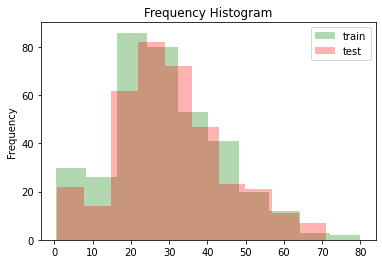

In [102]:
num_var = 'age'
kwargs = dict(alpha=0.3, bins=10)

plt.hist(train[num_var], **kwargs, color='g', label='train')
plt.hist(test[num_var], **kwargs, color='r', label='test')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')
plt.legend();

# PSI in R

Package ‘smbinning’ - 2019:  
https://cran.r-project.org/web/packages/smbinning/smbinning.pdf


Package ‘creditmodel’ Jun-2021  
https://cran.r-project.org/web/packages/creditmodel/creditmodel.pdf


Package ‘scorecard’ - Sept-2021  
https://cran.r-project.org/web/packages/scorecard/scorecard.pdf

